In [ ]:
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
from torch import nn
import torchvision.transforms as T
from IPython.display import clear_output
from torch.utils.data import DataLoader

Набор данных состоит из рентгеновских снимков здоровых людей и людей, которые больны пневмонией. Ниже приведен пример:

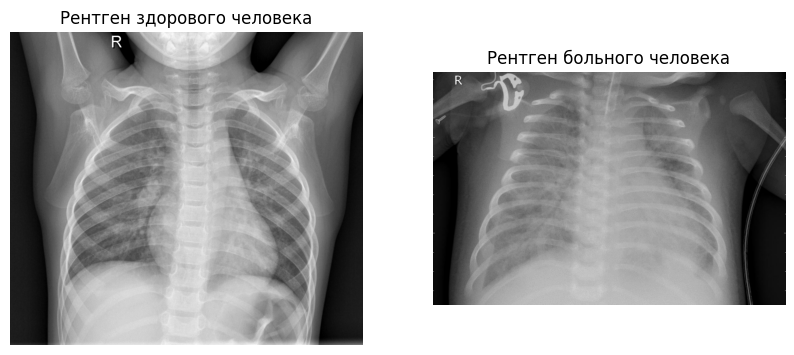

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(plt.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), cmap='gray')
ax[0].set_title('Рентген здорового человека')
ax[0].axis('off')
ax[0].set_axis_off()

ax[1].imshow(plt.imread('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'), cmap='gray')
ax[1].set_title('Рентген больного человека')
ax[1].axis('off')
ax[1].set_axis_off()

Реализуем обработчик данных, так как необходимо привести данные в определенный формат для корректной работы PyTorch.

In [3]:
train_transform = T.Compose([
            T.RandomHorizontalFlip(0.5),# Случайное горизонтальное отражение изображений с вероятностью 0.5
            T.RandomPerspective(0.5),# Случайная перспективная трансформация изображений с вероятностью 0.5
            T.RandomRotation(60),# Случайный поворот изображений на угол до ±60 градусов
            T.Resize((224, 224)),# Изменение размера изображений до размера 224x224 пикселей
            T.ToTensor(),# Преобразование изображений в тензоры
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),# Нормализация изображений с использованием заданных средних и стандартных отклонений
])

test_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Загрузка данных с использованием заданных трансформаций
train_dataset = torchvision.datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train", transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test", transform=test_transform)

# Создание DataLoader для тренировочного и тестового датасетов
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 300, shuffle=False)

Далее пропишем основные функции программы. Описание функций представлено ниже.

In [19]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    """
    Функция для построения графиков тренировочных и тестовых потерь, 
    а также тренировочной и тестовой точности в течение эпох.

    Args:
    - train_losses (list): Список тренировочных потерь для каждой эпохи.
    - test_losses (list): Список тестовых потерь для каждой эпохи.
    - train_accuracies (list): Список тренировочной точности для каждой эпохи.
    - test_accuracies (list): Список тестовой точности для каждой эпохи.
    
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

def train_one_epoch(model, train_dataloader, test_dataloader, criterion, optimizer,scheduler,
                   train_losses, test_losses, train_accuracies, test_accuracies, 
                    epoch, n_epochs, device="cuda:0"):
    """
    Функция для выполнения одной эпохи тренировки и валидации модели.

    Args:
    - model (torch.nn.Module): Нейронная сеть.
    - train_dataloader (torch.utils.data.DataLoader): DataLoader для тренировочного датасета.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader для тестового датасета.
    - criterion: Функция потерь.
    - optimizer: Оптимизатор для обновления параметров модели.
    - scheduler: Планировщик шага обучения.
    - train_losses (list): Список для хранения тренировочных потерь.
    - test_losses (list): Список для хранения валидационных потерь.
    - train_accuracies (list): Список для хранения тренировочной точности.
    - test_accuracies (list): Список для хранения валидационной точности.
    - epoch (int): Номер текущей эпохи.
    - n_epochs (int): Общее количество эпох.
    - device (str): Устройство для вычислений ('cuda:0' или 'cpu').

    """
    model.train()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_dataloader, desc=f'Training {epoch}/{n_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
    scheduler.step(running_loss)
        
    train_losses += [running_loss / len(train_dataloader.dataset)]
    train_accuracies += [running_accuracy / len(train_dataloader.dataset)]
    
    model.eval()
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_dataloader, desc=f'valing {epoch}/{n_epochs}'):
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        
        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()
        
    test_losses += [running_loss / len(test_dataloader.dataset)]
    test_accuracies += [running_accuracy / len(test_dataloader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)


def predict(model, test_dataloder, criterion, device="cuda:0"):
    """
    Функция для предсказания результатов на валидационном датасете.

    Args:
    - model (torch.nn.Module): Нейронная сеть.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader для тестового датасета.
    - criterion: Функция потерь.
    - device (str): Устройство для вычислений ('cuda:0' или 'cpu').

    Returns:
    - losses (torch.tensor): Тензор с потерями для каждого изображения.
    - predicted_classes (torch.tensor): Тензор с предсказанными классами.
    - true_classes (torch.tensor): Тензор с истинными классами.
    """
    model.to(device)
    model.eval()
    predicted_classes = torch.tensor([]).to(device)
    true_classes = torch.tensor([]).to(device)
    losses = torch.tensor([]).to(device)
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)
        predicted_classes = torch.cat([predicted_classes, logits.argmax(dim=-1)])
        true_classes = torch.cat([true_classes, labels])
        losses = torch.cat([losses, torch.tensor([loss]).to(device)])
    return losses, predicted_classes, true_classes

def train(model, train_dataloader, test_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    """
    Функция для тренировки нейронной сети.

    Args:
    - model (torch.nn.Module): Нейронная сеть.
    - train_dataloader (torch.utils.data.DataLoader): DataLoader для тренировочного датасета.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader для тестового датасета.
    - criterion: Функция потерь.
    - optimizer: Оптимизатор для обновления параметров модели.
    - device (str): Устройство для вычислений ('cuda:0' или 'cpu').
    - n_epochs (int): Общее количество эпох.
    - scheduler: Планировщик шага обучения.

    """
    model.to(device)
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(n_epochs):
        train_one_epoch(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler,
                        train_losses, test_losses, train_accuracies, test_accuracies, 
                        epoch, n_epochs, device)

Используем предобученную модель ResNet-18 для решения задачи классификации изображений рентгеновских снимков на наличие пневмонии.


In [20]:
from torchvision.models import resnet18

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = resnet18(pretrained=True)
model.fc = nn.Sequential(
            nn.Linear(512, 128),# Линейный слой с входом размерности 512 и выходом размерности 128
            nn.BatchNorm1d(128),# Batch normalization для стабилизации обучения
            nn.ReLU(),# Функция активации ReLU для введения нелинейности
            nn.Dropout(0.3),# Dropout для регуляризации и предотвращения переобучения
            nn.Linear(128, 16),# Линейный слой с входом размерности 128 и выходом размерности 16
            nn.ReLU(),# Функция активации ReLU
            nn.Linear(16, 2)# Выходной линейный слой с выходной размерностью 2 (для классификации на 2 класса)
        )
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
n_epochs = 30

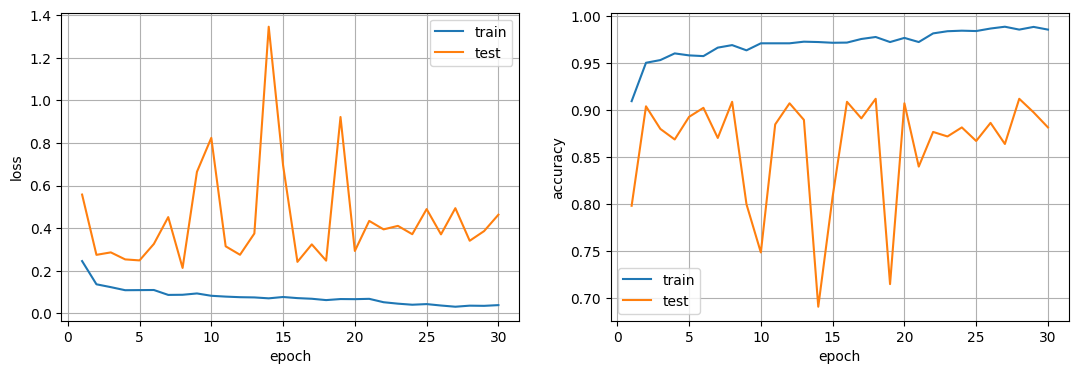

In [21]:
train(model, train_dataloader, test_dataloader, criterion, optimizer, device, n_epochs, scheduler)

По графикам видно, что наша нейронная сеть вышла в точность приблизительную 0.88.

Теперь реализуем модель GradientBoostingClassifier для сравнения с нашей нейронной сетью.

Для начала необходимо преобразовать наши тренировочный и тестовый датасеты в необходимый формат

In [24]:
from pathlib import Path
from PIL import Image
import numpy as np
import os

def read_images_and_labels(folder_path, label, target_size=(224, 224)):
    """
    Функция для чтения изображений и их меток из заданной папки.

    Args:
    - folder_path (str): Путь к папке с изображениями.
    - label (int): Метка класса для изображений в данной папке.
    - target_size (tuple): Целевой размер изображений после изменения.

    Returns:
    - images (list): Список массивов изображений.
    - labels (list): Список меток класса для каждого изображения.
    """
    images = []
    labels = []
    for image_file in os.listdir(folder_path):
        with Image.open(os.path.join(folder_path, image_file)) as img:
            img = img.convert('L')  # Преобразуем изображение в черно-белый формат
            img = img.resize(target_size)  # Изменяем размер изображения
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels


def prepare_dataset(train_folder, test_folder):
    """
    Функция для подготовки датасета изображений.

    Args:
    - train_folder (str): Путь к папке с тренировочными данными.
    - test_folder (str): Путь к папке с тестовыми данными.

    Returns:
    - X_train (np.array): Массив тренировочных изображений.
    - y_train (np.array): Массив меток классов для тренировочных изображений.
    - X_test (np.array): Массив тестовых изображений.
    - y_test (np.array): Массив меток классов для тестовых изображений.
    """
    train_folder = Path(train_folder)
    test_folder = Path(test_folder)
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Чтение и обработка тренировочных данных
    for label, folder_name in enumerate(['NORMAL', 'PNEUMONIA']):
        images, labels = read_images_and_labels(train_folder / folder_name, label)
        X_train.extend(images)
        y_train.extend(labels)

    # Чтение и обработка тестовых данных
    for label, folder_name in enumerate(['NORMAL', 'PNEUMONIA']):
        images, labels = read_images_and_labels(test_folder / folder_name, label)
        X_test.extend(images)
        y_test.extend(labels)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# пути к датасетам
train_folder = "../input/chest-xray-pneumonia/chest_xray/train"
test_folder = "../input/chest-xray-pneumonia/chest_xray/test"

# вызов функции
X_train, y_train, X_test, y_test = prepare_dataset(train_folder, test_folder)

# Проверка размеров
print("Размер тренировочного набора данных:", X_train.shape, y_train.shape)
print("Размер тестового набора данных:", X_test.shape, y_test.shape)

Размер тренировочного набора данных: (5216, 224, 224) (5216,)
Размер тестового набора данных: (624, 224, 224) (624,)


Импортируем необходимые библиотеки. StandardScaler будем использовать для масштабирования данных.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [26]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [27]:
model = GradientBoostingClassifier(verbose=3)

In [28]:
model.fit(X_train_scaled, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0419           71.74m
         2           0.9603           71.03m
         3           0.8908           70.32m
         4           0.8307           69.67m
         5           0.7813           68.89m
         6           0.7370           68.18m
         7           0.6996           67.43m
         8           0.6633           66.70m
         9           0.6312           65.95m
        10           0.5981           65.23m
        11           0.5713           64.48m
        12           0.5460           63.75m
        13           0.5242           63.01m
        14           0.5009           62.29m
        15           0.4804           61.55m
        16           0.4615           60.86m
        17           0.4445           60.12m
        18           0.4278           59.40m
        19           0.4130           58.68m
        20           0.3992           57.95m
        21           0.3870           57.22m
        2

GradientBoostingClassifier(verbose=3)

In [29]:
pred = model.predict(X_test_scaled)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.951     0.248     0.393       234
           1      0.687     0.992     0.812       390

    accuracy                          0.713       624
   macro avg      0.819     0.620     0.603       624
weighted avg      0.786     0.713     0.655       624



Точность модели GradientBoostingClassifier равна 0.713, что ниже, чем точность нашей нейронной сети.